In [1]:
from brian2 import *
from brian2tools import *
%matplotlib inline

In [29]:
slots = 10 # This is the number of neurons used to represent a vector
bits = 16 # This is the number of bit positions
mem_size = 10 # The number of vectors against which the resulting unbound vector is compared
Num_bound = 2 # The number of vectors that are to be bound
input_delay = bits # Time delay between adding cyclically shifted vectors to construct the bound vector is set to 'bits' milliseconds.

#NB all timings use milliseconds and we can use a random seed if required.
#np.random.seed(54321)

target_neuron = 1
y_low=target_neuron-1 # This is used to select the lowest index of the range of neurons that are to be displayed
y_high=target_neuron+1 # This is used to select the highest index of the range of neurons that are to be displayed

delta = (2*Num_bound+2)*bits #This determins the time period over which the Brian2 simulation is to be run.

# Generate a random matrix (P_matrix) which represents all of the sparse vectors that are to be used.
# This matrix has columns equal to the number of slots in each vector with the number of rows equal to the memory size (mem_size)

P_matrix = np.random.randint(0, bits, size=(mem_size,slots))
min_match=slots

In [30]:
print(P_matrix)

[[ 1  3  9  9 11  9  0  0  9  3]
 [ 3 13 15  3 14  6  7  1 13 12]
 [ 1 15  0  2  4 12 15  5 14 13]
 [ 3  4 13 15  8 14  5 14  4  7]
 [11  5 11 13  0  6  7  2  9  8]
 [ 5  2  7  7 14 10  8 12 10 13]
 [ 6 12 10  0  6 15  1 14  9  5]
 [ 4 12 11  1 10 15 10  5 13 10]
 [ 5  9  6 12  7 13 15  9  5 14]
 [10  3  0  6  1  8  0  1  1 15]]


In [31]:
#This section of the code implements the role/filler binding in the Brian2 network (net1)

net1=Network()

#We first create an array of time delays which will be used to select the first Num_bound vectors from 
# the P_matrix with a time delay (input_delay) between each vector.


# Calculate the array for the input spike generator
array1 = ones(mem_size)*slots*bits

# The input spike generator creates pairs of spkies corresponding to contiguous pairs of vectors from the memory 
# that are going to be bound together (i.e., vector_0 & vector_1 then vector_2 and Vector_3 etc.)

for b in range(0,2*Num_bound,2):
    array1[b] = (b)*input_delay
    array1[b+1] = (b)*input_delay

# Create the corresponding spike generator group.
P = SpikeGeneratorGroup(mem_size,arange(mem_size), (array1)*ms)

net1.add(P)

In [32]:
print(array1)

[  0.   0.  32.  32. 160. 160. 160. 160. 160. 160.]


In [33]:
#SMP = SpikeMonitor(P)
#net1.add(SMP)

In [34]:
#net1.run(100*ms)

In [35]:
#brian_plot(SMP)

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


<synapses_6.i: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int32)>
<synapses_6.j: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>
<synapses_6_pre.delay: array([ 1.,  3.,  9.,  9., 11.,  9.,  0.,  0.,  9.,  3.,  3., 13., 15.,
        3., 14.,  6.,  7.,  1., 13., 12.,  1., 15.,  0.,  2.,  4., 12.,
       15.,  5., 14., 13.,  3.,  4., 13., 15.,  8., 14.,  5., 14.,  4.,
        7., 11.,  5., 11., 13.,

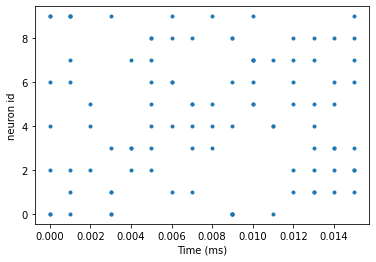

In [36]:
#We now define the set of equation and reset definitions that will be used to generate the neuron action
#potentials and spike reset operations.  Note that we make use of the Brian2 refractory operation.

equ1 ='''
dv/dt = (I)/tau : 1 (unless refractory)
I : 1
tau : second
'''

equ2 = '''
dv/dt = -v/tau : 1 
I : 1
vt : 1
tau : second
'''
reset1 = '''
I=0.0
v=0.0
'''
reset2 = '''
vt += v
v=0.0
'''

# The G1 neurons perform the addition operation in the two selected vectors. Equ1 is a linearly increasing function 
# with a time constant of 2*bits*ms (I=1.0).  The G1 neuron group is stimulated from the P spike generator group with 
# spikes that simultaneously select a role and filler vector using the time delay on the G1 dendrites obtained from the P_matrix (S0.delay)
# On receiving the first spike from either role or filler vector the value of I
# is changed to 0.0 which holds the neuron potential constant until the second spike is received when I = -1.0 and the neuron
#  potential decays until the threshold value v<0.0 when it fires to give the required modulus addition. The value of I is 
# reset to 1.0 using the spike from the P spikemonitorgroup (S1) and the next two vectors are added.

G1 = NeuronGroup(slots, equ1,
                 threshold='v < 0.0 or v>=1.0',reset=reset1, method='euler')

G1.v =0.0
G1.I = 1.0
G1.tau = 2*bits*ms

net1.add(G1)


S0 = Synapses(P, G1, 'w : 1',on_pre= 'I = (I-1)')

range_array1 = range(0,slots)
for n in range(0,mem_size):
    S0.connect(i=n,j=range_array1)     
S0.delay = reshape(P_matrix,mem_size*slots)*ms

net1.add(S0)

print(S0.i)
print(S0.j)
print(S0.delay)
#brian_plot(S0)
plot(S0.delay, S0.i, '.')
xlabel('Time (ms)')
ylabel('neuron id');
net1.run(140*ms)

In [37]:
print(S0.w)

<synapses_6.w: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>


<AxesSubplot:xlabel='source neuron index', ylabel='target neuron index'>

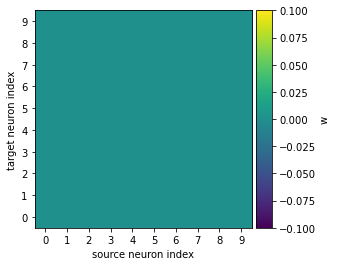

In [38]:
brian_plot(S0.w)

In [39]:
S1 = Synapses(P, G1, 'w : 1',on_pre= 'I=1.0')

for n in range(0,mem_size):
    S1.connect(i=n,j=range_array1)    

net1.add(S1)

In [40]:
print(range_array1)

range(0, 10)


![fred](img/role_filler_binding01.png)

<AxesSubplot:xlabel='source neuron index', ylabel='target neuron index'>

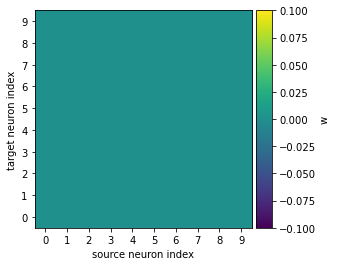

In [41]:
brian_plot(S1.w)

In [42]:
# NeuronGroup G2 performs the recurrent bundling operation (note there is no cyclic shift here)

G2 = NeuronGroup(slots, equ2, threshold='v >= 1.0', reset='v=v', method='euler')

G2.v = 0.0
G2.tau = 0.5*ms

net1.add(G2)
S2 = Synapses(G1, G2, 'w : 1', on_pre='v += 1.25' )
S2.connect(j='i') 

net1.add(S2)

S3 = Synapses(G2, G2, 'w : 1', on_pre='v +=1.25' )
S3.connect(j='i') 
S3.delay = (bits-0.1)*ms

net1.add(S3)

The resulting vector from the recurrent superposition operation is a dense vector. To create the corresponding sparse vector the G4 and G5 neuron groups work together to perform the Argmax operation. 

The G4 neurons perform part of this operation by using a variable spike threshold such that if spikes from the superposed vectors have the same time delay then they will only exceed the threshold if the same number of aligne spikes has not occured earlier.

The G5 neurons then use a linear decaying neuron potential to create a single spike per slot which is the required sparse bound vector.



In [43]:


G4 = NeuronGroup(slots, model=equ2, reset=reset2, threshold='v>=vt',method='euler',refractory='t<(2*Num_bound)*bits*ms')


G4.v = 1.0
G4.vt = -0.5
G4.I = 1.0
G4.tau =0.25*ms

net1.add(G4)

S4 = Synapses(G2, G4, 'w : 1', on_pre='v +=1.0')
S4.connect(j='i') 

net1.add(S4)

G5 = NeuronGroup(slots, equ1,
                 threshold='v <= 0.0', reset='v=1.0', method='euler',refractory = 't< (2*Num_bound)*bits*ms')


G5.v = 0.0
G5.I = -1.0
G5.tau = bits*ms

net1.add(G5)

argmax_synapse = Synapses(G4, G5, 'w : 1', on_pre='v = 1.0')
argmax_synapse.connect(j='i') 

net1.add(argmax_synapse)


In [44]:
# Create the required monitors

SMP = SpikeMonitor(P)
net1.add(SMP)
M1 = StateMonitor(G1, 'v', record=True)
net1.add(M1)
SM1= SpikeMonitor(G1)
net1.add(SM1)
M2 = StateMonitor(G2, 'v', record=True)
net1.add(M2)
SM2= SpikeMonitor(G2)
net1.add(SM2)
SM4 = SpikeMonitor(G4)
net1.add(SM4)
M4 = StateMonitor(G4, 'vt', record=True)
net1.add(M4)
M5 = StateMonitor(G4, 'v', record=True)
net1.add(M5)
SM5 = SpikeMonitor(G5)
net1.add(SM5)
M6 = StateMonitor(G5, 'v', record=True)
net1.add(M6)

In [45]:
# Run Net1 for delta milliseconds

net1.run(delta*ms, report='text')

Starting simulation at t=140. ms for a duration of 96. ms
96. ms (100%) simulated in < 1s


Obtain the sparse vector timings from the SM5 monitor to compare with the theoretical values.

[ 76 151 135 103 119 117  76 149 133 101 123 107  76 155 139  76 103 151
 119 135 135 151  76 119 103  76 108 140  92 124  76 136 152 120 104 131
 147  76 115  99 134 102 118 150  76 124 107 140  76]


<AxesSubplot:xlabel='time (ms)', ylabel='neuron index'>

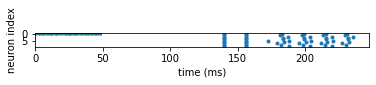

In [46]:
print('Obtain the sparse vector timings from the SM5 monitor to compare with the theoretical values.')
array2 = np.array([SM5.i,SM5.t/ms])
sub_array2 = array2[0:2,slots:]
print()
sorted_sub_array2 = sub_array2[:,sub_array2[0].argsort()].astype(int) - (2*Num_bound+1)*bits
P1_timing = sorted_sub_array2[1]
print(P1_timing)
imshow(sorted_sub_array2)
brian_plot(SM5)

<AxesSubplot:xlabel='time (ms)', ylabel='neuron index'>

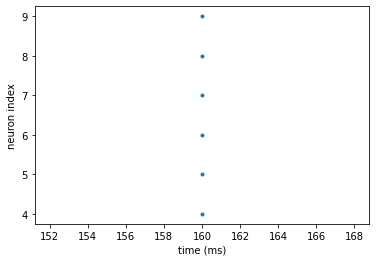

In [47]:
# The following plots output from the different monitors
# subplot(4,2,1)
# plot(SMP.t/ms, SMP.i,'|')
# xlabel('Time (ms)')
# ylabel('P Neuron id')
brian_plot(SMP)

In [48]:
# plt.ylim(0,10)
# plt.xlim(0,2*bits*Num_bound)
# plt.xlim(9700,10800)


Text(0, 0.5, 'G1 Neuron Voltage')

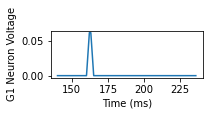

In [49]:
subplot(4,2,2)
plot(M1.t/ms, M1.v[target_neuron].T)
xlabel('Time (ms)')
ylabel('G1 Neuron Voltage')

Text(0, 0.5, 'G2 Neuron Voltage')

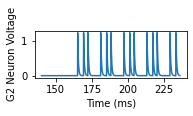

In [50]:
subplot(4,2,3)
plot(M2.t/ms, M2.v[target_neuron].T)
xlabel('Time (ms)')
ylabel('G2 Neuron Voltage')

Text(0, 0.5, 'G1 Neuron id')

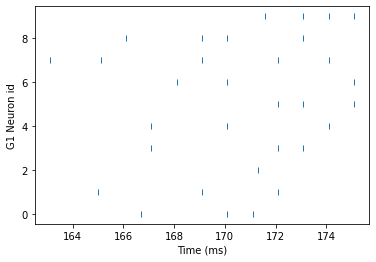

In [51]:
plot(SM1.t/ms, SM1.i,'|')
xlabel('Time (ms)')
ylabel('G1 Neuron id')

Text(0, 0.5, 'G2 Neuron id')

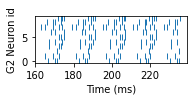

In [52]:
subplot(4,2,4)
plot(SM2.t/ms, SM2.i,'|')
xlabel('Time (ms)')
ylabel('G2 Neuron id')

Text(0, 0.5, 'G4 Threshold Voltage')

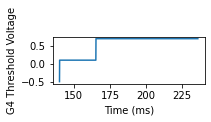

In [53]:
subplot(4,2,5)
plot(M4.t/ms, M4[target_neuron].vt.T)
xlabel('Time (ms)')
ylabel('G4 Threshold Voltage')

Text(0, 0.5, 'G4 Neuron id')

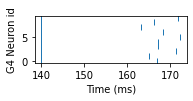

In [54]:
subplot(4,2,6)
plot(SM4.t/ms, SM4.i,'|')
xlabel('Time (ms)')
ylabel('G4 Neuron id')

Text(0, 0.5, 'G5 Neuron Voltage')

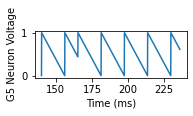

In [55]:
subplot(4,2,7)
plot(M6.t/ms, M6.v[target_neuron].T)
xlabel('Time (ms)')
ylabel('G5 Neuron Voltage')

(80.0, 96.0)

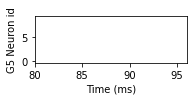

In [56]:
subplot(4,2,8)
plot(SM5.t/ms, SM5.i,'|')
xlabel('Time (ms)')
ylabel('G5 Neuron id')
#plt.ylim(y_low,y_high)
plt.xlim((2*Num_bound+1)*bits,(2*Num_bound+2)*bits)

## BELOW we perform unbinding of the previously bound vectors
This section of the code implements the Brian2 neuromorphic circuit which unbinds the vector. 
The unbound vector and a selected role vector are processed to give the corresponding 'noisy' filler vector.
which is then compared to the memory vectors to find the best match (i.e. the clean-up memory operation)

We first generate the time delay data_matrix which will be used in the 'clean-up memory'  so that the input vector 
time delay in each slot plus the delay matrix line up at the number of bits per slot 
(e.g. a time delay in slot 0 of the input vector of say 10 will have a corresponding delay of 90 in the corresponding
data_matrix so that if this vector is received then the match condition is an input potential to the neuron at 
100)

In [57]:
data_matrix = bits - P_matrix

net2=Network()
# To pass the sparse vector from Net1 into Net2 we create a SpikeGeneratorGroup that uses the P1_timing from Net1 to generate
# the sparse bound vector which is the input to NeuronGroup G6 (S6).

P1 = SpikeGeneratorGroup(slots,np.arange(slots), P1_timing*ms)

net2.add(P1)

# We now define the neuron potential equations and resets plus a preset
equ2 = '''
dv/dt = -v/tau : 1 
I : 1
tau : second
'''

# equ3 ='''
# dv/dt = (I)/tau : 1 
# I : 1
# tau : second
# '''

# reset3 = '''
# I=1.0
# v=0.0
# '''
# preset1 = '''
# I = 1.0
# v= 0.0
# '''

# NeuronGroup G7 is a recurrent circuit which simply repeates the sparse bound vector from P1 every 3*bits milliseconds 
# and feeds the output vector into the G6 neurongroup (see S7 below)

G7 = NeuronGroup(slots, equ2,threshold='v>=1.0',reset='v=0.0', method='euler')
G7.v=0.0
G7.tau = 0.5*ms

SP17 = Synapses(P1, G7, 'w : 1',on_pre= 'v=1.25')
SP17.connect(j='i')
SP17.delay = bits*ms

S77 = Synapses(G7, G7, 'w : 1',on_pre= 'v=1.25')
S77.connect(j='i')
S77.delay = 3*bits*ms

net2.add(G7)
net2.add(SP17)
net2.add(S77)

ValueError: Length of the indices and times array must match, but 10 != 49

In [ ]:
#Calculate the array for the input spike generator which cycles through the role vectors 0,2,4 etc
array2 = np.ones(mem_size)*slots*bits
for b in range(0,Num_bound):
    array2[b*2] = (b*3)*input_delay

P2 = SpikeGeneratorGroup(mem_size,np.arange(mem_size), (array2)*ms)
net2.add(P2)


The G6 neuron group is stimulated from the P spike generator group with and the G7 neuron group.
The P spike generator generates a role vector role using the time delay on the G6 dendrites obtained from the P_matrix (S5.delay)
and the G6 neuron group produces the sparse bound vector.

The G6 neurons perform the subtraction operation on the selected vectors. In this case Equ3 is a linearly increasing function 
with a time constant of bits*ms (I=1.0).  On receiving the first spike from either role or filler vector the value of I=0.0
which holds the neuron potential constant until the second spike is received when I again becomes 1.0  and the neuron
 potential continues to increase until the threshold value v>1.0 when it fires. To give the required modulus addition the value 
of I is maintained at 1.0 to ensure a second vector is generated. One of these two vector will have the correct modulus timings and so we compare both vectors in the final 
neuron group stage (G8) to get the best match. 

In [ ]:
equ3 ='''
dv/dt = (I)/tau : 1 
I : 1
tau : second
'''
reset3 = '''
I=1.0
v=0.0
'''
preset1 = '''
I = 1.0
v= 0.0
'''

G6 = NeuronGroup(slots, equ3,threshold='v>=1.0',reset=reset3, method='euler')

G6.v =0.0
G6.I = 1.0
G6.tau = bits*ms

net2.add(G6)

S5 = Synapses(P2, G6, 'w : 1',on_pre= 'I = (I-1)%2')

range_array2 = range(0,slots)
for n in range(0, mem_size):
    S5.connect(i=n,j=range_array2)     
    
S5.delay = np.reshape(P_matrix,mem_size*slots)*ms
net2.add(S5)

S6 = Synapses(P2, G6, 'w : 1',on_pre= preset1)
for n in range(0,mem_size):
    S6.connect(i=n,j=range_array2)    

net2.add(S6)


S7 = Synapses(G7, G6, 'w : 1',on_pre= 'I = (I-1)%2')
S7.connect(j='i')

net2.add(S7)


This final NeuronGroup,G8, stage is the clean up memory operation using the transpose of the data_matrix to set the synaptic delays on the G8 dendrites. We only produce one output spike per match by using the refractory operator to suppress any further spikes. This could be improved to choose the larget matching spike.

In [ ]:

G8 = NeuronGroup(mem_size, equ2, threshold='v >= min_match-0.5', reset='v=0.0', method='euler',refractory='2*bits*ms')

G8.v = 1.0
G8.tau = 2.0*ms

net2.add(G8)

range_array3 = range(0,mem_size)

S8 = Synapses(G6, G8, on_pre='v += 1.0')

for n in range(0,slots):
    S8.connect(i=n,j=range_array3)  

data_matrix2 = np.transpose(data_matrix) 
S8.delay = np.reshape(data_matrix2,mem_size*slots)*ms
net2.add(S8)

# Create the required monitors

SMP1 = SpikeMonitor(P1)

net2.add(SMP1)

SM7 = SpikeMonitor(G7)
net2.add(SM7)

SMP2 = SpikeMonitor(P2)

net2.add(SMP2)

M6 = StateMonitor(G6, 'v', record=True)

net2.add(M6)

SM6 = SpikeMonitor(G6)

net2.add(SM6)


M8 = StateMonitor(G8, 'v', record=True)

net2.add(M8)

SM8 = SpikeMonitor(G8)

net2.add(SM8)

net2.run(((3*Num_bound+1)*bits)*ms, report='text')


In [ ]:
# Plot the sparse bound vector

plot(SMP1.t/ms, SMP1.i,'|')
xlabel('Time (ms)')
ylabel('P Neuron id')

In [ ]:
subplot(6,1,1)
plot(SM7.t/ms, SM7.i,'|')
xlabel('Time (ms)')
ylabel('P1 Neuron id')
plt.ylim(0,slots)

In [ ]:
subplot(6,1,2)
plot(SMP2.t/ms, SMP2.i,'|')
xlabel('Time (ms)')
ylabel('P2 Neuron id')

In [ ]:
subplot(6,15,3)
plot(M6.t/ms, M6.v[0].T)
xlabel('Time (ms)')
ylabel('G6 Neuron Voltage')

In [ ]:
subplot(6,1,4)
plot(SM6.t/ms, SM6.i,'|')
xlabel('Time (ms)')
ylabel('G6 Neuron id')

In [ ]:
brian_plot(SM6)

In [ ]:
subplot(6,1,5)
plot(M8.t/ms, M8.v.T)
xlabel('Time (ms)')
ylabel('G8 Neuron Voltage')

In [ ]:
brian_plot(M8)

In [ ]:
subplot(6,1,6)
plot(SM8.t/ms, SM8.i,'|')
xlabel('Time (ms)')
ylabel('G8 Neuron id')